# A/B тестирование: бутстрап

#### Постановка задачи

Есть два варианта размещения баннера, сообщающего о начале распродаж, на главной странице интернет-магазина. Необходимо проверить, влияет ли размещение баннера на размер покупки.

#### Формулирование гипотез

Нулевая гипотеза: положение баннера не влияет на размер покупки. 
Альтернативная гипотеза: положение баннера влияет на размер покупки (двусторонняя гипотеза). 
Уровень значимости = 0.05.

#### Дизайн эксперимента

Участников эксперимента необходимо разделить на две группы. Каждой группе будет показан разный вариант размещения баннера. Обозначим варианты как type_1 и type_2.

#### Выборка

Так как данный эксперимент ограничен по времени, удалось собрать 350 наблюдений.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

data = pd.read_csv('test_data_2.csv')
data.head()

,user_id,timestamp,group,buy_sum
0,681363,2021-12-20 00:27:53,type_1,2638
1,684228,2021-12-20 00:34:36,type_2,1488
2,521050,2021-12-20 00:44:17,type_1,2737
3,597384,2021-12-20 00:50:29,type_2,2722
4,717110,2021-12-20 00:53:05,type_1,904


In [2]:
data['group'].value_counts()

type_1    181
type_2    169
Name: group, dtype: int64

Наблюдения распределены следующим образом: 181 показ баннера type_1, 169 показов баннера type_2.

#### Обработка данных

In [3]:
# проверка наличия пропусков

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    350 non-null    int64 
 1   timestamp  350 non-null    object
 2   group      350 non-null    object
 3   buy_sum    350 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 8.3+ KB


Пропущенных значений в датафрейме нет.

In [4]:
# проверка повторяющихся пользователей

len(data['user_id'].unique()) == data.shape[0]

False

In [5]:
len(data['user_id'].unique())

349

In [6]:
data[data.duplicated('user_id', keep=False)]

,user_id,timestamp,group,buy_sum
264,250200,2021-12-22 07:52:27,type_1,698
270,250200,2021-12-22 09:58:28,type_1,1045


Как видим, один из пользователей, участвовавших в эксперименте, совершил в разное время две покупки. Так как данному покупателю оба раза был продемонстрирован баннера type_1, то можно просто суммировать обе его покупки.

In [7]:
results = data.groupby(['user_id', 'group'], as_index=False).sum()
results['group'].value_counts()

type_1    180
type_2    169
Name: group, dtype: int64

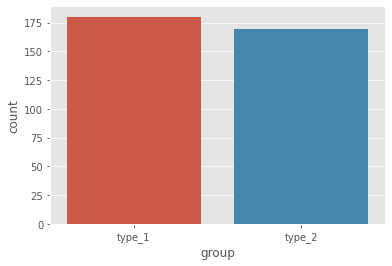

In [8]:
plt.style.use('ggplot')
sns.countplot(x='group', data=results)
plt.show()

Таким образом, в итоговый датафрейм вошли 180 наблюдений группы type_1 и 169 наблюдений группы type_2.

#### Проверка гипотезы

Для начала посмотрим на распределение сумм покупок в каждой группе.

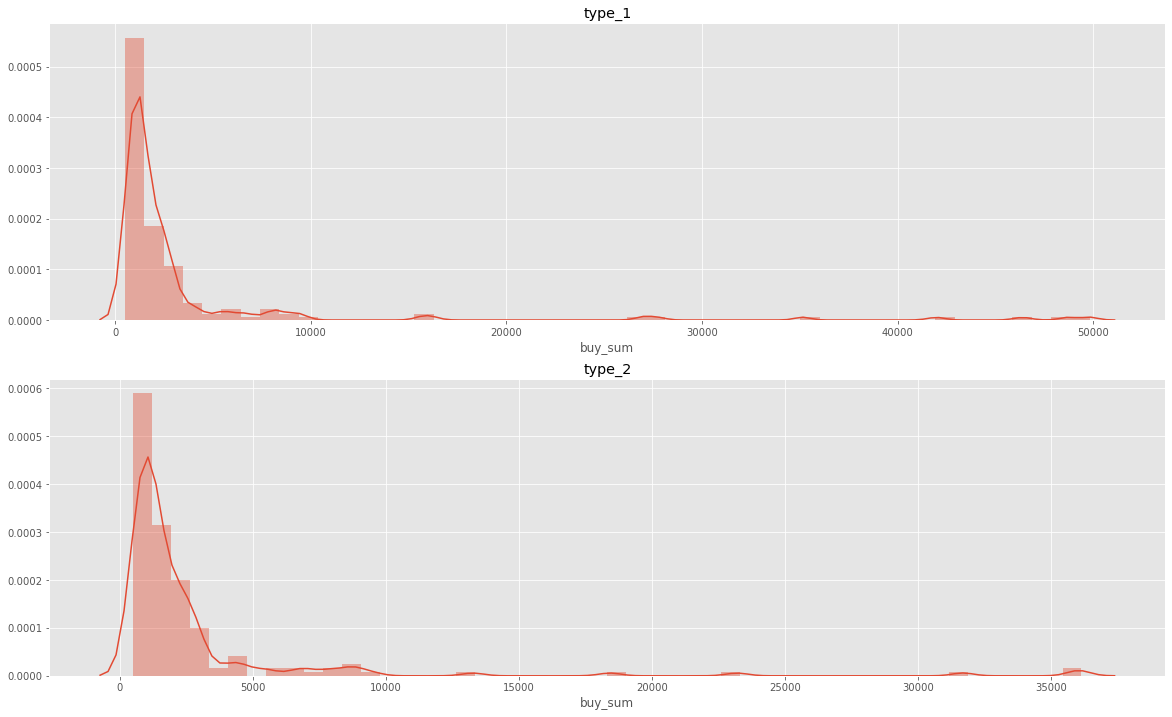

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))
sns.distplot(results[results.group == 'type_1']['buy_sum'], ax=axes[0])
sns.distplot(results[results.group == 'type_2']['buy_sum'], ax=axes[1])
axes[0].set_title('type_1')
axes[1].set_title('type_2')
plt.show()

Распределение асимметрично, большая часть покупок - заказы на небольшую сумму.

Посмотрим на описательные статистики в разрезе групп.

In [10]:
results.groupby('group').describe()['buy_sum']

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
type_1,180.0,3625.355556,7796.049494,505.0,1027.75,1451.5,2557.5,49811.0
type_2,169.0,2803.177515,5147.584262,505.0,908.00,1323.0,2382.0,36139.0


Как видим, среднее значение и медиана больше в группе type_1. Проверим, являются ли отличия статистически значимыми. Так как мы располагаем небольшим количеством наблюдений, и распределение отличается от нормального, для проверки гипотезы вопользуемся бутстрапом. 
Будем сравнивать медианы бутстрапированных выборок. 
Прежде всего, убедимся, что метод работает, и внутри каждой из выборок существенных различий нет (AA тест).

In [11]:
# разделим выборки на две группы

group_type_1_shuffled = results[results.group == 'type_1'].sample(frac=1)
group_type_2_shuffled = results[results.group == 'type_2'].sample(frac=1)
type_1_1 = group_type_1_shuffled.iloc[:group_type_1_shuffled.shape[0] // 2, :]
type_1_2 = group_type_1_shuffled.iloc[group_type_1_shuffled.shape[0] // 2:, :]
type_2_1 = group_type_1_shuffled.iloc[:group_type_2_shuffled.shape[0] // 2, :]
type_2_2 = group_type_1_shuffled.iloc[group_type_2_shuffled.shape[0] // 2:, :]

# применим бутстрап 

print('type_1_1: ', stats.bootstrap(data=(type_1_1['buy_sum'],), 
                              statistic=np.median, 
                              confidence_level=0.95,
                              method='basic'))
print('type_1_2: ', stats.bootstrap(data=(type_1_2['buy_sum'],), 
                              statistic=np.median, 
                              confidence_level=0.95,
                              method='basic'))

type_1_1:  BootstrapResult(confidence_interval=ConfidenceInterval(low=1313.5, high=1625.0), standard_error=96.61769880053997)
type_1_2:  BootstrapResult(confidence_interval=ConfidenceInterval(low=909.0, high=1694.5), standard_error=215.89990706509303)


В группе type_1 доверительные интервалы для медиан в подвыборках пересекаются, следовательно, бутстрап верно указал, что значимых различий нет. Проведем аналогичную проверку для группы type_2. 

In [12]:
print('type_2_1: ', stats.bootstrap(data=(type_2_1['buy_sum'],), 
                              statistic=np.median, 
                              confidence_level=0.95,
                              method='basic'))
print('type_2_2: ', stats.bootstrap(data=(type_2_2['buy_sum'],), 
                              statistic=np.median, 
                              confidence_level=0.95,
                              method='basic'))

type_2_1:  BootstrapResult(confidence_interval=ConfidenceInterval(low=1185.5, high=1546.5), standard_error=111.23340687708989)
type_2_2:  BootstrapResult(confidence_interval=ConfidenceInterval(low=1015.0, high=1777.0), standard_error=186.7031020721162)


В группе type_2 значимых различий между двумя подвыборками нет.
Теперь можем сравнить медианы обеих групп. 

In [13]:
print('type_1: ', stats.bootstrap(data=(group_type_1_shuffled['buy_sum'],), 
                              statistic=np.median, 
                              confidence_level=0.95,
                              method='basic'))
print('type_2: ', stats.bootstrap(data=(group_type_2_shuffled['buy_sum'],), 
                              statistic=np.median, 
                              confidence_level=0.95,
                              method='basic'))

type_1:  BootstrapResult(confidence_interval=ConfidenceInterval(low=1299.5, high=1637.0), standard_error=80.10423545286152)
type_2:  BootstrapResult(confidence_interval=ConfidenceInterval(low=1153.0, high=1425.0), standard_error=72.9286906184577)


Сравнение доверительных интервалов для двух групп свидетельствует об отсутствии значимых различий в медианном размере покупки. 
Кроме сравнения доверительных интервалов для каждой группы можно построить один доверительный интервал для медианы разности наблюдений в бутстрапированных выборках из групп type_1 и type_2:

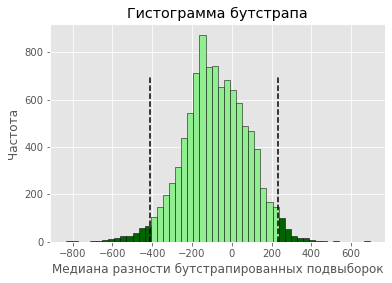

ДИ:              0
0.025 -408.525
0.975  230.500

p_value: 0.6221903076593153


In [14]:
# количество наблюдений в группах разное, поэтому будем извлекать подвыборки размером, равным 
# количеству наблюдений в большей из групп

boot_len = max([len(type_1_1), len(type_1_2)])

# извлекаем бутстрапированные подвыборки и добавляем в список boot_data медиану разности значений

boot_data = []
for i in range(9999):
    samples_x = type_1_1['buy_sum'].sample(boot_len, replace=True).values
    samples_y = type_1_2['buy_sum'].sample(boot_len, replace = True).values
    boot_data.append(np.median(samples_x - samples_y)) 

# находим критические значения и p-value для медианы разности наблюдений 
# в бутстрапированных выборках из групп type_1 и type_2
    
df_boot_data = pd.DataFrame(boot_data)
quants = df_boot_data.quantile([0.025, 0.975])
p_1 = stats.norm.cdf(x = 0, 
                    loc = np.mean(boot_data), 
                    scale = np.std(boot_data))
p_2 = stats.norm.cdf(x = 0, 
                    loc = -np.mean(boot_data), 
                    scale = np.std(boot_data))
p_value = min(p_1, p_2) * 2

# визуализация результатов

fig, ax, bars = plt.hist(df_boot_data[0], bins = 50)
for bar in bars:
    if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
        bar.set_facecolor('darkgreen')
        bar.set_edgecolor('black')
    else: 
        bar.set_facecolor('lightgreen')
        bar.set_edgecolor('black')
    
plt.vlines(quants, ymin = 0, ymax = max(boot_data), linestyle = '--')
plt.xlabel('Медиана разности бутстрапированных подвыборок')
plt.ylabel('Частота')
plt.title("Гистограмма бутстрапа")
plt.show()
       
print("ДИ:", quants) 
print()
print("p_value:", p_value)

#### Вывод

Так как p-value значительно превышает уровень значимости 0.05, у нас нет оснований для отклонения нулевой гипотезы: размещение баннера на странице не оказывает существенного влияния на размер покупки.